In [1]:
import numpy as np
import pickle
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gseapy as gp
from random import sample

In [27]:
# Define the root directory
name = 'Dataset-ppi--RE-True--W-1--Epochs-5000--D-8--RH-25--LR-0.1--LP-False--CUDA-True'
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'
# W = True

In [28]:
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_index.pkl', 'rb') as f:
    string2node = pickle.load(f)
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_name2stringId.pkl', 'rb') as file:
    name2stringId = pickle.load(file)
node2string = {v: k for k, v in string2node.items()}
stringId2name = {v: k for k, v in name2stringId.items()}
# Specify the variable names
# variable_names = ['k_exp_dist','final_idx', 'general_cl_id', 'general_mask']
variable_names = ['k_exp_dist', 'general_cl_id', 'general_mask']
# Initialize a dictionary to store the loaded variables
loaded_variables = {}

# Loop through the variable names and load the data from pickle files
for var_name in variable_names:
    file_path = os.path.join(root, name, var_name + '.pkl')
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    loaded_variables[var_name] = loaded_data

# Access the loaded variables as needed
k_exp_dist = loaded_variables['k_exp_dist']
# final_idx = loaded_variables['final_idx']
general_cl_id = loaded_variables['general_cl_id']
general_mask = loaded_variables['general_mask']

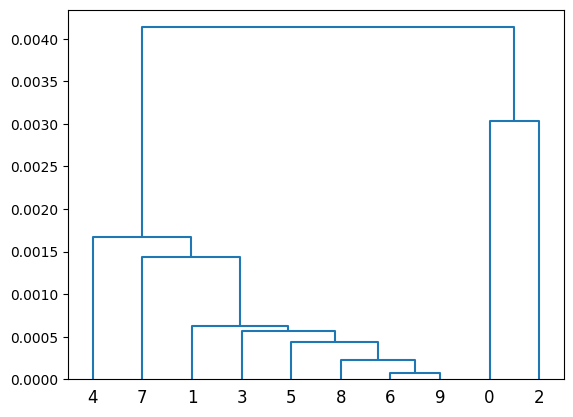

In [29]:
k_exp_dist = np.array(k_exp_dist)
# Create your matrix of within-cluster Euclidean distances
first_level_cls = len(set(list(general_cl_id[0])))
distance_matrix = k_exp_dist[:first_level_cls,:first_level_cls]
# distance_matrix = k_exp_dist[30:70,30:70]
# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='average')
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=0)

# plt.title('Post-Processing Agglomerative Clustering Dendrogram')
# plt.xlabel('Clusters')
# plt.ylabel('Euclidean Distance')
# plt.savefig(pltroot+'Dendrogram-'+name+'.png')
# plt.show()

order = dendrogram['leaves']

In [30]:
level_list = []
# check the cluster ids in different levels
for i in general_cl_id:
    a = list(set(i))
    level_list.append(a)
index_dict = dict()
for i, l in enumerate(general_cl_id):
    for j, cluster in enumerate(l):
        if cluster in index_dict:
            index_dict[cluster].append(general_mask[i][j])
        else:
            index_dict[cluster] = [general_mask[i][j]]
level_dict = dict()
for i in range(len(level_list)):
    if i == len(level_list)-1:
        l = level_list[i]
        for c1 in l:
            level_dict[c1] = []
    else:
        l = level_list[i]
        subl = level_list[i+1]
        # print(l,subl)
        for c1 in l:
            # print(c1)
            for c2 in subl:
                # print(c2)
                if set(index_dict[c1]) & set(index_dict[c2]):
                    # print(c2 ,'in',c1)
                    if c1 in level_dict:
                        level_dict[c1].append(c2)
                    else:
                        level_dict[c1] = [c2]
            if c1 not in level_dict:
                level_dict[c1] = []
G1 = nx.DiGraph()

# Add nodes and edges based on the dictionary
for node, neighbors in level_dict.items():
    G1.add_node(node)
    G1.add_edges_from((node, neighbor) for neighbor in neighbors)
def find_end_nodes(graph, start_node, visited=None):
    if visited is None:
        visited = set()
    visited.add(start_node)
    
    neighbors = list(graph.neighbors(start_node))
    
    # Check if the current node has no outgoing edges
    if not neighbors:
        return [start_node]
    
    end_nodes = []
    for neighbor in neighbors:
        if neighbor not in visited:
            end_nodes.extend(find_end_nodes(graph, neighbor, visited))
    
    return end_nodes

end_orders = []
for i in order:
    start_node = i
    end_nodes = find_end_nodes(G1, start_node)
    end_orders.extend(end_nodes)

index = []
for i in end_orders:
    index.extend(index_dict[i])
len(index)
def find_deep_end_nodes(graph, start_node, depth, current_depth=0, visited=None):
    if visited is None:
        visited = set()
    visited.add(start_node)
    
    neighbors = list(graph.neighbors(start_node))
    
    # Check if the current node is at the desired depth
    if current_depth == depth:
        return [start_node]
    
    deep_end_nodes = []
    for neighbor in neighbors:
        if neighbor not in visited:
            deep_end_nodes.extend(find_deep_end_nodes(graph, neighbor, depth, current_depth + 1, visited))
    
    return deep_end_nodes
df = pd.DataFrame({'node':range(max(list(set(general_mask[0])))+1)})
for i, level in enumerate(general_cl_id):
    clusters = list(set(level))
    col = []
    ori_index = []
    colname = 'level_'+str(i+1)
    for key in clusters:
        col += len(index_dict[key])*[int(key)]
        ori_index.extend(index_dict[key])
    dftemp = pd.DataFrame({'node': ori_index, colname: col})
    df = df.merge(dftemp,how='left')

In [31]:
file_path = os.path.join(root, name ,'latent.pkl')
with open(file_path, 'rb') as f:
    node_rep = pickle.load(f)
node_rep = np.array(node_rep)
df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index
df = pd.merge(df,df_latent)

In [32]:
df.head(3)

,node,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,1d,2d,3d,4d,5d,6d,7d,8d
0,0,0,11,33,77,164.0,335.0,654.0,1132.0,NaN,NaN,NaN,1.048601,0.206645,1.765595,-1.995435,-1.921027,-0.481104,2.222914,-1.777296
1,1,0,11,33,76,163.0,333.0,650.0,1125.0,1604.0,1920.0,NaN,0.914282,0.418759,3.601322,-3.814427,-0.760032,-2.609666,2.808699,-1.168192
2,2,0,10,30,71,152.0,310.0,605.0,1061.0,1559.0,NaN,NaN,-1.016299,0.239654,-0.211125,-0.648027,1.318484,-1.243678,-0.359989,1.151029


In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # You can choose the number of components based on your preference
pca_result = pca.fit_transform(df[['1d', '2d', '3d', '4d', '5d', '6d', '7d', '8d']])

# Create a new DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['level_1']

In [43]:
pca_df

,PC1,PC2,cluster
0,0.874930,3.076443,0
1,0.973412,4.453583,0
2,-2.470162,-1.350084,0
3,8.916916,-2.585220,6
4,2.627685,-0.234682,7
...,...,...,...
18753,2.941800,-1.488173,8
18754,-4.253129,5.691074,5
18755,-9.140801,-4.686010,2
18756,-3.673120,-4.600803,2


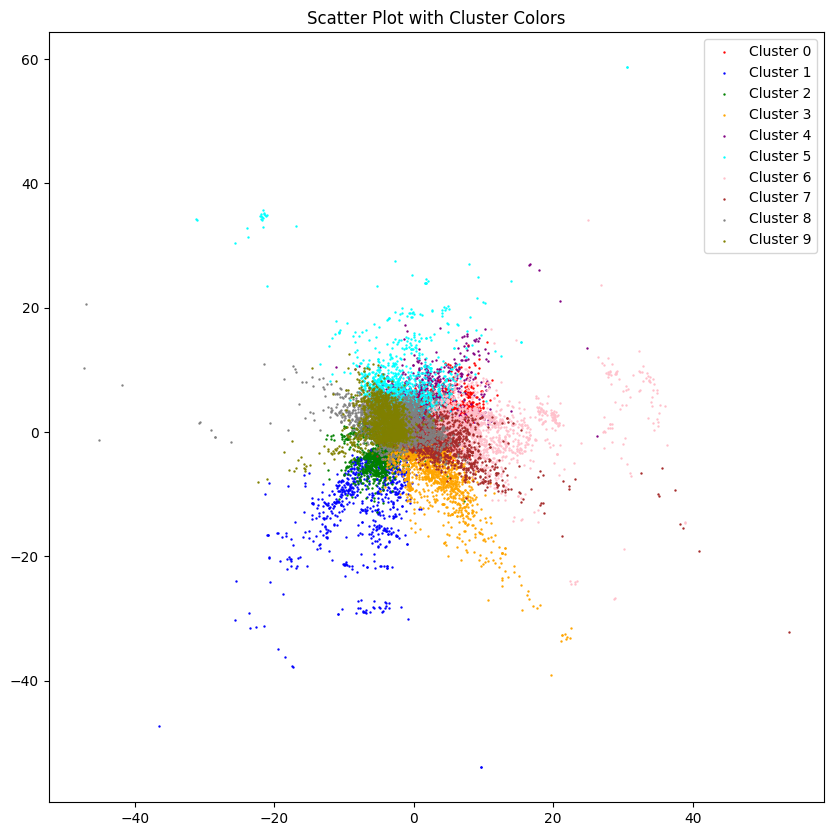

In [47]:
x = pca_df['PC1']
y = pca_df['PC2']
clusters = pca_df['cluster']

# Define 10 distinct colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink', 'brown', 'gray', 'olive']

# Scatter plot with discrete colors
plt.figure(figsize=(10, 10))
for cluster, color in zip([0,1,2,3,4,5,6,7,8,9], colors):
    cluster_data = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], color=color, label=f'Cluster {cluster}',s=0.5)


plt.title('Scatter Plot with Cluster Colors')

# Add legend
plt.legend()

# Display the plot
plt.show()